In [2116]:
import pandas as pd
from collections import Counter
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.genres import *
from src.utils.genres import name_plot, count_genre_over_years, top_years_for_genre, bottom_years_for_genre, count_genres_by_year, calc_genre_differences, calc_genre_growth, calc_proportion_growth
import warnings
import csv
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
from nltk.sentiment import SentimentIntensityAnalyzer
from src.utils import google_trends as gt
warnings.simplefilter("ignore")
from scipy.signal import find_peaks
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

In [2117]:
# Import data
data = pd.read_csv("data/data_Q1.csv")
df_wars = pd.DataFrame(data)
df_movies = pd.read_csv("data/filtered_movie_data.csv")
# Filtering the data considering years in the dataframes
df_wars = df_wars[(df_wars["StartYear"] >= 1931) & (df_wars["EndYear"] <= 2012)]
df_movies = df_movies[(df_movies["Year"] >= 1931) & (df_movies["Year"] <= 2012)]

In [2118]:
'''
Looking for genres based on the chosen key words in order to find interesting and appropriate genres to inspect
'''

# Get the unique genres
df_movies['Genres'] = df_movies['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
exploded_genres = df_movies.explode('Genres')
unique_genres = exploded_genres['Genres'].unique()

# List of word parts to search for in genres
search_terms = ["war", "spy", "patriot", "propagand", "hero", "social", "politic", "apocalyp", "topia"]
pattern = '|'.join(search_terms)  

# Filter genres
matching_genres = [genre for genre in unique_genres if isinstance(genre, str) and pd.Series(genre).str.contains(pattern, case=False, na=False).any()]

# Print the matching genres
print(matching_genres)


['War film', 'Political drama', 'Superhero movie', 'Spy', 'Political cinema', 'Dystopia', 'Political satire', 'Social issues', 'Social problem film', 'Propaganda film', 'Gulf War', 'Political thriller', 'Superhero', 'Apocalyptic and postapocalyptic fiction', 'Antiwar', 'Antiwar film', 'Glamorized Spy Film', 'Nuclear warfare', 'Cold War', 'War effort', 'Patriotic film', 'Political Documetary', 'The Netherlands in World War II']


In [2119]:
'''
Cleaning function for genres that are almost the same and have slight differences, like the word 'Film' included, 
change all genre_2 to genre_1 for future analysis.

Parameters:
- df_movies: movie data
- genre_1: genre to keep
- genre_2: similar genre to change for the first one
'''
def clean_genres(df_movies, genre_1, genre_2):
    
    df_movies['Genres'] = df_movies['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df_movies['Genres'] = df_movies['Genres'].apply(lambda genres: list(set([genre if genre != genre_2 else genre_1 for genre in genres])))
    return df_movies

# Do the cleaning for similar genres found earlier
df_movies = clean_genres(df_movies, "Superhero", "Superhero movie")
df_movies = clean_genres(df_movies, "Antiwar", "Antiwar film")
df_movies = clean_genres(df_movies, "Social issues", "Social problem film")
df_movies = clean_genres(df_movies, "Spy", "Glamorized Spy Film")
df_movies = clean_genres(df_movies, "Family Film", "Family")
df_movies = clean_genres(df_movies, "Romance Film", "Romance")

# Identified the genres from the list that are encountered too rarely for analysis
print(count_genre_over_years(df_movies, "Patriotic film")["Count"].sum())
print(count_genre_over_years(df_movies, "Nuclear warfare")["Count"].sum())
print(count_genre_over_years(df_movies, "War effort")["Count"].sum())
print(count_genre_over_years(df_movies, "Political Documetary")["Count"].sum())

2.0
2.0
1.0
1.0


In [2120]:
def analyze_genre_wars(df_movies, df_wars, genre_name):
    '''
    Analyze the top 10 peak years for a given genre and find the relevant wars
    that occurred during +-2 years of those peak years.

    Parameters:
    - df_movies: DataFrame containing movie data 
    - df_wars: DataFrame containing war data 
    - genre_name: The genre of films to analyze 
    '''
    # Count genre over years
    genre_films = count_genre_over_years(df_movies, genre_name)
    # Count genre proportion over years
    genre_films_proportion = count_genre_proportion(df_movies, genre_name)

    # Find the peaks in the proportion vs. time figure
    peak_indices, _ = find_peaks(genre_films_proportion["Proportion"])
    # Extract the peak years and corresponding values
    peak_years = genre_films_proportion.iloc[peak_indices]["Year"]
    peak_values = genre_films_proportion.iloc[peak_indices]["Proportion"]


    peaks_df = pd.DataFrame({
        'Year': peak_years,
        'Proportion': peak_values
    })
    # Select top 10 peaks
    top_peaks = peaks_df.sort_values(by="Proportion", ascending=False).head(10)
    # Extract top 10 peak years
    top_peak_years = top_peaks['Year'].values

    # Define the +-2 time interval
    time_intervals = []
    for year in top_peak_years:
        start_year = year - 2
        end_year = year + 2
        time_intervals.append((start_year, end_year))

    # Find the wars that happened during those time intervals
    wars_in_intervals = []
    # Use a set to store unique war names for further intersection
    unique_wars = set()  

    for start_year, end_year in time_intervals:
        # Filter wars for the time interval
        relevant_wars = df_wars[
            (((start_year <= df_wars['StartYear']) & (df_wars['StartYear'] <= end_year)) |
             ((start_year <= df_wars['EndYear']) & (df_wars['EndYear'] <= end_year)) |
             ((df_wars['StartYear'] < start_year) & (df_wars["EndYear"] > end_year)))
        ]

        for _, war in relevant_wars.iterrows():
            if war['WarName'] not in unique_wars:
                unique_wars.add(war['WarName'])
                
                # Find the closest peak year that fits in the interval
                peak_year_for_war = None
                for peak_year in top_peak_years:
                    if peak_year - 2 <= war['StartYear'] <= peak_year + 2 or peak_year - 2 <= war['EndYear'] <= peak_year + 2 or\
                    ((war['StartYear'] < peak_year - 2) & (war['EndYear'] > peak_year + 2)):
                        peak_year_for_war = peak_year
                        break
 
                wars_in_intervals.append((war['StartYear'], war['EndYear'], war['WarName'], peak_year_for_war))

    # Results
    wars_in_intervals_df = pd.DataFrame(wars_in_intervals, columns=["Start Year", "End Year", "War Name", "Peak Year"])

    return genre_films_proportion['Year'], genre_films_proportion['Proportion'], wars_in_intervals_df

In [2121]:
# Identified the genres to inspect, grouped the genres into groups of similar theme for further analysis
inspected_genres = ["War film", "Spy", "Superhero", "Antiwar", "Social issues", "Political satire", "Political thriller", "Political cinema", "Political drama", "Dystopia", "Apocalyptic and postapocalyptic fiction"]
military_genres = ["War film", "Spy", "Superhero"]
military_and_antiwar = ["War film", "Spy", "Superhero", "Antiwar"]
reflecting_genres = ["Political satire", "Political thriller", "Political cinema", "Political drama"]
dystopian_genres = ["Dystopia", "Apocalyptic and postapocalyptic fiction"]
positive_genres = ["Family Film", "Romance Film", "Comedy", "Romantic comedy", "Fantasy"]

In [2122]:
'''
Function that calculates the number of ongoing wars for each year
'''
def wars_per_year():
    '''
    Calculate how many wars were ongoing each year.
    '''
    # Unifying the 2 rows for each war into one
    df_agg = df_wars.groupby(['WarName', 'StartYear', 'EndYear'], as_index=False)['BatDeath'].sum()
    min_year = df_agg['StartYear'].min()
    max_year = df_agg['EndYear'].max()

    all_years = range(min_year, max_year + 1)
    ongoing_counts = []
    
    for year in all_years:
        count = ((df_agg['StartYear'] <= year) & (df_agg['EndYear'] >= year)).sum()
        ongoing_counts.append(count)

    ongoing_df = pd.DataFrame({
        'Year': all_years,
        'Count': ongoing_counts
    })

    return ongoing_df

def inspect_peaks_events(genre_list, ylim, name):
    '''
    For identified lists of genres sum up the releases of all genres for each year and plot vs. year. Plot the number of ongoing wars
    to make observations. Find the events for the peaks.
    
    Parameters:
    - genre_list: list of genres to analyze
    - ylim: y-axis limit for proportions
    - name: the name of the inspected list
    '''
    fig = go.Figure()

    peak_wars = []
    combined_data = pd.DataFrame()

    # Use the analyze_genre_wars function for all genres in the list and combine the data
    for genre in genre_list:
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)  # Retrieve data
        
        # Combine data into a single DataFrame: Years as index, proportions as values
        temp_df = pd.DataFrame({'Year': genre_data[0], 'Proportion': genre_data[1]})
        if combined_data.empty:
            combined_data = temp_df
        else:
            combined_data = combined_data.merge(temp_df, on="Year", how="outer", suffixes=("", f"_{genre}"))

        peak_wars.append(genre_data[2][["War Name", "Peak Year"]])

    # Sum proportions across all genres for each year and replace Null values with 0
    combined_data = combined_data.fillna(0) 
    combined_data['Total Proportion'] = combined_data.drop(columns='Year').sum(axis=1)

    # Plot the summed proportions as a single line
    fig.add_trace(go.Scatter(
        x=combined_data['Year'], 
        y=combined_data['Total Proportion'], 
        mode='lines', 
        name=f"Total Proportion ({name})",
        line=dict(width=3, color='blue')
    ))

    # Calculate intersection of "War Names" across all genres in the list
    intersection = set(peak_wars[0]['War Name'])
    for genre_data in peak_wars[1:]:
        intersection = intersection.intersection(set(genre_data['War Name']))

    final_df = pd.DataFrame(list(intersection), columns=["War Name"])

    # Ongoing Wars. Calculate and add to the plot with a second y-axis
    ongoing_wars_df = wars_per_year()
    fig.add_trace(go.Scatter(
        x=ongoing_wars_df['Year'], 
        y=ongoing_wars_df['Count'],
        mode='lines+markers',
        name='Ongoing Wars',
        yaxis='y2',
        line=dict(color='purple', width=2, dash='dot'),
        marker=dict(size=5, color='purple')
    ))

    # Update the layout
    fig.update_layout(
        title=f"{name} Production Trends and Ongoing Wars Over Time",
        xaxis=dict(title="Year", gridcolor='lightgray'),
        yaxis=dict(title=f"Proportion ({name})", color='blue', range=[0, ylim]),
        yaxis2=dict(
            title="Number of Ongoing Wars",
            overlaying='y',
            side='right',
            color='red',
            range=[0, 10]
        ),
        legend=dict(
            x=1,
            y=1,
            xanchor='right',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor="Black",
            borderwidth=1
        ),
        template="plotly_white",
        width=1000,
        height=600
    )

    fig.show()

    # Print the intersected wars for inspection
    print(final_df)
    return final_df

military_events = inspect_peaks_events(military_genres, 0.1, "Military Genres")
mil_antiwar_peaks = inspect_peaks_events(military_and_antiwar, 0.1, "Military and Antiwar Genres")
polit_peaks = inspect_peaks_events(reflecting_genres, 0.02, "Political Genres")
dystop_peaks = inspect_peaks_events(dystopian_genres, 0.004, "Dystopian and Antiapocalyptic Genres")

                   War Name
0      Conquest of Ethiopia
1       Third Sino-Japanese
2                 Iran-Iraq
3              World War II
4               Changkufeng
5             Russo-Finnish
6              Arab-Israeli
7               Franco-Thai
8                  Cold War
9      Vietnam War, Phase 2
10                 Nomonhan
11            First Kashmir
12           Second Kashmir
13  Second Laotian, Phase 2


                   War Name
0       Third Sino-Japanese
1                 Iran-Iraq
2              World War II
3             Russo-Finnish
4               Changkufeng
5              Arab-Israeli
6            Second Kashmir
7               Franco-Thai
8                  Cold War
9      Vietnam War, Phase 2
10            First Kashmir
11                 Nomonhan
12  Second Laotian, Phase 2


                    War Name
0               Badme Border
1                  Iran-Iraq
2   Sino-Vietnamese Punitive
3         Ugandian-Tanzanian
4                   Cold War
5             Azeri-Armenian
6       Vietnam War, Phase 2
7      Bangladesh Liberation
8    Second Laotian, Phase 2
9              Turco-Cypriot
10            Yom Kippur War
11       Communist Coalition
12      Vietnamese-Cambodian


                      War Name
0                    Iran-Iraq
1     Sino-Vietnamese Punitive
2        Bangladesh Liberation
3              War over Angola
4           Ugandian-Tanzanian
5                Cenepa Valley
6               Yom Kippur War
7                     Cold War
8   Second Ogaden War, Phase 2
9         Vietnam War, Phase 2
10              Azeri-Armenian
11     Second Laotian, Phase 2
12              Second Kashmir
13               Turco-Cypriot
14                       Assam
15         Communist Coalition
16        Vietnamese-Cambodian


In [2123]:
'''
From the final_df's produced for each group of genres, find the wars that appear in at least 2 dataframes and filter for more than 2000 movies released
in the period of the war in order to define the wars most interesting for further analysis.
'''

military_events = set(military_events['War Name'])
mil_antiwar_peaks = set(mil_antiwar_peaks['War Name'])
polit_peaks = set(polit_peaks['War Name'])
dystop_peaks = set(dystop_peaks['War Name'])

# Combine all sets into a list for easier iteration
war_name_sets = [military_events, mil_antiwar_peaks, polit_peaks, dystop_peaks]

# Use a dictionary to count occurrences of each war name across the DataFrames
from collections import Counter

war_name_counter = Counter()

# Count occurrences of each war name in the union of all sets
for war_set in war_name_sets:
    war_name_counter.update(war_set)

# Get the list of war names that appear in at least two DataFrames
at_least_two = [war for war, count in war_name_counter.items() if count >= 2]

print("War Names present in at least 2 dataframes:", at_least_two)
movies_released = {}
for warname in at_least_two:
    war = df_wars[df_wars["WarName"] == warname]
    starting = war["StartYear"].values[0]
    ending = war["EndYear"].values[0]
    releases = df_movies[(df_movies["Year"] >= starting) & (df_movies["Year"] <= ending)].shape[0]
    movies_released[warname] = releases
    
filtered_wars = {key: value for key, value in movies_released.items() if value >= 2000}
print(filtered_wars)

War Names present in at least 2 dataframes: ['Third Sino-Japanese', 'Iran-Iraq', 'World War II', 'Changkufeng', 'Russo-Finnish', 'Arab-Israeli', 'Second Kashmir', 'Franco-Thai', 'Cold War', 'Vietnam War, Phase 2', 'First Kashmir', 'Nomonhan', 'Second Laotian, Phase 2', 'Sino-Vietnamese Punitive', 'Ugandian-Tanzanian', 'Yom Kippur War', 'Azeri-Armenian', 'Bangladesh Liberation', 'Turco-Cypriot', 'Communist Coalition', 'Vietnamese-Cambodian']
{'Iran-Iraq': 4412, 'World War II': 2162, 'Cold War': 18052, 'Vietnam War, Phase 2': 4246, 'Second Laotian, Phase 2': 2384}


In [2124]:
'''
DataFrame with the chosen wars
'''
wars_inspect = []
chosen_wars = pd.DataFrame()
for k, v in filtered_wars.items():
    wars_inspect.append(k)
    thewar = df_wars[df_wars["WarName"] == k]
    chosen_wars = pd.concat([chosen_wars, thewar], ignore_index=True)
chosen_wars = chosen_wars[~chosen_wars["WarName"].duplicated(keep='first')]
print(chosen_wars)

                   WarName  Side  StartYear  EndYear  \
0                Iran-Iraq     1       1980     1988   
2             World War II     1       1939     1945   
4                 Cold War     1       1947     1991   
6     Vietnam War, Phase 2     1       1965     1975   
8  Second Laotian, Phase 2     1       1968     1973   

                                           StateName    BatDeath  
0                                           ['Iran']    750000.0  
2  ['Belgium', 'Yugoslavia', 'Norway', 'Canada', ...  10717907.0  
4                          ['United States America']         0.0  
6                                        ['Vietnam']    700000.0  
8                                        ['Vietnam']      2250.0  


In [2125]:
'''
Calculate total battle death in a year for all years
'''
def calc_bat_deaths():
    # Adding duration column. For a war we consider that the Battle Death for the war was evenly distributed across the years of the war
    df_aggregated = df_wars.groupby(['WarName', 'StartYear', 'EndYear'], as_index=False)['BatDeath'].sum()
    df_aggregated['Duration'] = df_aggregated['EndYear'] - df_aggregated['StartYear'] + 1

    expanded_df = df_aggregated.loc[df_aggregated.index.repeat(df_aggregated['Duration'])].copy()
    expanded_df['Year'] = expanded_df.groupby(level=0).cumcount() + expanded_df['StartYear']
    expanded_df['Count'] = expanded_df['BatDeath'] / expanded_df['Duration']
    yearly_deaths = expanded_df.groupby('Year')['Count'].sum().reset_index()

    min_year = df_aggregated['StartYear'].min()
    max_year = df_aggregated['EndYear'].max()
    all_years = pd.DataFrame({'Year': range(min_year, max_year + 1)})

    final_df = pd.merge(all_years, yearly_deaths, on='Year', how='left').fillna(0)
    return final_df

def inspect_peaks_events_with_batdeath(genre_list, ylim):
    """
    The same function as previously but for battle death
    """
    fig = go.Figure()

    combined_data = pd.DataFrame()
    for genre in genre_list:
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        temp_df = pd.DataFrame({'Year': genre_data[0], 'Proportion': genre_data[1]})
        if combined_data.empty:
            combined_data = temp_df
        else:
            combined_data = combined_data.merge(temp_df, on="Year", how="outer", suffixes=("", f"_{genre}"))

    combined_data = combined_data.fillna(0)
    combined_data['Total Proportion'] = combined_data.drop(columns='Year').sum(axis=1)

    fig.add_trace(go.Scatter(
        x=combined_data['Year'],
        y=combined_data['Total Proportion'],
        mode='lines',
        name='Total Proportion (All Genres)',
        line=dict(width=3, color='blue')
    ))

    total_batdeath_df = calc_bat_deaths()

    fig.add_trace(go.Scatter(
        x=total_batdeath_df['Year'],
        y=total_batdeath_df['Count'],
        mode='lines+markers',
        name='Total Battle Deaths',
        yaxis='y2',
        line=dict(color='red', width=2, dash='dot'),
        marker=dict(size=5, color='red')
    ))

    fig.update_layout(
        title="Film Production Trends and Total Battle Deaths Over Time",
        xaxis=dict(title="Year", gridcolor='lightgray'),
        yaxis=dict(
            title="Proportion (All Genres)", 
            color='blue', 
            range=[0, ylim]
        ),
        yaxis2=dict(
            title="Total Battle Deaths", 
            overlaying='y', 
            side='right', 
            color='red', 
            range=[0, 0.15 * (10 ** 6)]
        ),
        legend=dict(
            x=1, y=1, xanchor='right', yanchor='top',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor="Black", borderwidth=1
        ),
        template="plotly_white",
        width=1000,
        height=600
    )
    fig.show()

inspect_peaks_events_with_batdeath(military_genres, 0.07)
inspect_peaks_events_with_batdeath(military_and_antiwar, 0.07)
inspect_peaks_events_with_batdeath(reflecting_genres, 0.02)
inspect_peaks_events_with_batdeath(dystopian_genres, 0.004)


In [2126]:
def correlation_genre_cut(genredf, otherdf, year_cut1, year_cut2):
    '''
    Filter both DataFrames to the given year range and calculate Pearson correlation.
    '''
    otherdf_filtered = otherdf[(otherdf["Year"] >= year_cut1) & (otherdf["Year"] <= year_cut2)]
    genredf_filtered = genredf[(genredf["Year"] >= year_cut1) & (genredf["Year"] <= year_cut2)]

    if len(genredf_filtered) < 2 or len(otherdf_filtered) < 2:
        print("Not enough data points for correlation in given year range.")
        return np.nan, np.nan

    return stats.pearsonr(genredf_filtered["Proportion"], otherdf_filtered["Count"])

def plot_proportion_vs_number_wars(genre_df, wars_df, genre_name, year_cut1, year_cut2):
    '''
    Plots the proportion of a genre's movies vs. the number of wars and the OLS.
    Filters data by year_cut1 and year_cut2 and calculates Pearson correlation.
    '''
    # Filter by year range the passed genre_df and wars_df and merge together
    genre_filtered = genre_df[(genre_df["Year"] >= year_cut1) & (genre_df["Year"] <= year_cut2)][["Year", "Proportion"]]
    wars_filtered = wars_df[(wars_df["Year"] >= year_cut1) & (wars_df["Year"] <= year_cut2)][["Year", "Count"]]

    merged_df = pd.merge(genre_filtered, wars_filtered, on="Year", how="inner")
    
    if len(merged_df) < 2:
        print(f"Not enough data to plot correlation for {genre_name} in {year_cut1}-{year_cut2}.")
        return

    correlation, p_value = correlation_genre_cut(genre_df, wars_df, year_cut1, year_cut2)

    fig = px.scatter(
        merged_df,
        x="Count",
        y="Proportion",
        trendline="ols",
        labels={"Count": "Number of Wars", "Proportion": f"Proportion of {genre_name} Movies"},
        title=f"Correlation Between {genre_name} Movies and Number of Wars ({year_cut1}-{year_cut2})<br>"
              f"<sup>Pearson Correlation: {correlation:.2f}, p={p_value:.5f}</sup>"
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7, color="blue"))
    fig.update_layout(
        xaxis_title="Number of Wars",
        yaxis_title=f"Proportion of {genre_name} Movies",
        template="plotly_white",
        width=900,
        height=600
    )

    fig.show()

def sum_genres_proportions(df_movies, genres):
    '''
    Sums up the yearly proportions of multiple genres in order to calculate the correlation for a group of genres
    '''
    combined_df = pd.DataFrame()

    for genre in genres:
        genre_yearly = count_genre_proportion(df_movies, genre)
        genre_yearly = genre_yearly[["Year", "Proportion"]].rename(columns={"Proportion": f"Proportion_{genre}"})

        if combined_df.empty:
            combined_df = genre_yearly
        else:
            combined_df = combined_df.merge(genre_yearly, on="Year", how="outer")
    if combined_df.empty:
        print(f"Error: No data available for genres {genres}. Returning None.")
        return None

    combined_df = combined_df.fillna(0)
    proportion_cols = [col for col in combined_df.columns if col.startswith("Proportion_")]
    combined_df["Proportion"] = combined_df[proportion_cols].sum(axis=1)
    
    return combined_df[["Year", "Proportion"]]

military_df = sum_genres_proportions(df_movies, military_genres)
military_antiwar_df = sum_genres_proportions(df_movies, military_and_antiwar)
reflecting_df = sum_genres_proportions(df_movies, reflecting_genres)
dystopian_df = sum_genres_proportions(df_movies, dystopian_genres)
positive_df = sum_genres_proportions(df_movies, positive_genres)

bat_deaths_yearly = calc_bat_deaths()
wars_yearly = wars_per_year()

'''
Define the ranges for the functions. 
(1931-2012) - overall range
(1950-2012) - overall without the WW2 specifically because the increased Battle Deaths skew the data
(1978-1990) - Iran-Iraq War
(1947-1991) - Cold War
(1963-1977) - Vietnam War, Phase 2 (2nd Laotian War not included due to very similar range of 1968-1975)
(1990-2012) - The interval was taken for further inspection since the 21st century was not represented in the intervals before
'''
year_ranges = [(1931, 2012), (1950, 2012), (1978, 1990), (1947, 1991), (1937, 1947), (1963, 1977), (1990, 2012)]

# List of single genres for inspection (Previosly not mentioned: Horror, Thriller, Disaster)
genres = ["War film", "Spy", "Superhero", "Romance Film", "Romantic drama", "Family Film", "Romantic comedy", 
          "Comedy", "Fantasy", "Thriller", "Horror", "Drama", "Social issues", "Antiwar", "Disaster"]

# Calculating the correlation and plotting proportion vs. number of wars with the OLS. Displaying only for the correlation value at least 0.45
for year_cut1, year_cut2 in year_ranges:
    for genre in genres:
        genre_yearly = count_genre_proportion(df_movies, genre)
        # Print correlation
        corr_val, p_val = correlation_genre_cut(genre_yearly, wars_yearly, year_cut1, year_cut2)
        if abs(corr_val) >= 0.45:
            print(f"{genre} and Number of Wars Correlation {year_cut1}-{year_cut2}:\n", corr_val, p_val)
            
            # Plot
            plot_proportion_vs_number_wars(genre_yearly, wars_yearly, genre, year_cut1, year_cut2)

    # Plot and print correlations for the groups of genres
    for name, df_genres in [("Military", military_df),
                            ("Military & Antiwar", military_antiwar_df),
                            ("Political", reflecting_df),
                            ("Dystopian", dystopian_df),
                            ("Positive", positive_df)]:
        corr_val, p_val = correlation_genre_cut(df_genres, wars_yearly, year_cut1, year_cut2)
        if abs(corr_val) >= 0.45:
            print(f"{name} Movies and Number of Wars Correlation {year_cut1}-{year_cut2}:\n", corr_val, p_val)
            plot_proportion_vs_number_wars(df_genres, wars_yearly, name, year_cut1, year_cut2)

Superhero and Number of Wars Correlation 1950-2012:
 -0.484137387377459 5.8151254544748465e-05


Romantic comedy and Number of Wars Correlation 1950-2012:
 -0.5606378599453922 1.7646923697819293e-06


Family Film and Number of Wars Correlation 1978-1990:
 0.45778661785706853 0.11571143063754763


Disaster and Number of Wars Correlation 1978-1990:
 0.5217145717502831 0.0674547168567818


Romantic comedy and Number of Wars Correlation 1947-1991:
 -0.4506173070283014 0.0018944734201382643


Thriller and Number of Wars Correlation 1937-1947:
 -0.49338964428287385 0.12301669448674728


Antiwar and Number of Wars Correlation 1937-1947:
 0.5448919310237997 0.08303212332938933


Disaster and Number of Wars Correlation 1937-1947:
 0.45759626678466764 0.1570051099098851


Family Film and Number of Wars Correlation 1963-1977:
 -0.6107573178148685 0.015583513073592506


Romantic comedy and Number of Wars Correlation 1963-1977:
 -0.4966499028999849 0.0596657679972246


Social issues and Number of Wars Correlation 1990-2012:
 -0.5008439056090079 0.014920703212376752


Political Movies and Number of Wars Correlation 1990-2012:
 -0.5483382551604977 0.006747061757120175


In [2127]:
def calc_bat_deaths():
    """Calculate total battle deaths per year by evenly distributing deaths across the duration of each war."""
    df_aggregated = df_wars.groupby(['WarName', 'StartYear', 'EndYear'], as_index=False)['BatDeath'].sum()
    df_aggregated['Duration'] = df_aggregated['EndYear'] - df_aggregated['StartYear'] + 1

    # Expand to have one row per year of each war
    expanded_df = df_aggregated.loc[df_aggregated.index.repeat(df_aggregated['Duration'])].copy()
    expanded_df['Year'] = expanded_df.groupby(level=0).cumcount() + expanded_df['StartYear']

    # Distribute BatDeath evenly across years
    expanded_df['Count'] = expanded_df['BatDeath'] / expanded_df['Duration']

    # Sum deaths by year
    yearly_deaths = expanded_df.groupby('Year')['Count'].sum().reset_index()

    # Include all years in the final DataFrame
    min_year = df_aggregated['StartYear'].min()
    max_year = df_aggregated['EndYear'].max()
    all_years = pd.DataFrame({'Year': range(min_year, max_year + 1)})

    final_df = pd.merge(all_years, yearly_deaths, on='Year', how='left').fillna(0)
    return final_df

def plot_proportion_vs_battle_deaths(genre_df, bat_deaths_df, genre_name, year_cut1, year_cut2):
    """
    Plots the relationship between a genre's proportion of movies and battle deaths and OLS.
    Filters data by the specified year range, calculates Pearson correlation.
    """
    # Filter by year range
    genre_filtered = genre_df[(genre_df["Year"] >= year_cut1) & (genre_df["Year"] <= year_cut2)][["Year", "Proportion"]]
    deaths_filtered = bat_deaths_df[(bat_deaths_df["Year"] >= year_cut1) & (bat_deaths_df["Year"] <= year_cut2)][["Year", "Count"]]

    merged_df = pd.merge(genre_filtered, deaths_filtered, on="Year", how="inner")

    if len(merged_df) < 2:
        print(f"Not enough data to plot correlation for {genre_name} in {year_cut1}-{year_cut2}.")
        return

    correlation, p_value = correlation_genre_cut(genre_df, bat_deaths_df, year_cut1, year_cut2)

    fig = px.scatter(
        merged_df,
        x="Count",
        y="Proportion",
        trendline="ols",
        labels={"Count": "Battle Deaths", "Proportion": f"Proportion of {genre_name} Movies"},
        title=f"Correlation Between {genre_name} Movies and Battle Deaths ({year_cut1}-{year_cut2})<br>"
              f"<sup>Pearson Correlation: {correlation:.2f}, p={p_value:.5f}</sup>"
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7, color="blue"))
    fig.update_layout(
        xaxis_title="Battle Deaths",
        yaxis_title=f"Proportion of {genre_name} Movies",
        template="plotly_white",
        width=900,
        height=600
    )

    fig.show()

bat_deaths_yearly = calc_bat_deaths()

genres = ["War film", "Spy", "Superhero", "Romance Film", "Romantic drama", "Family Film", 
          "Romantic comedy", "Comedy", "Fantasy", "Thriller", "Horror", 
          "Drama", "Social issues", "Antiwar", "Disaster"]

for year_cut1, year_cut2 in year_ranges:
    for genre in genres:
        genre_yearly = count_genre_proportion(df_movies, genre)
        corr_val, p_val = correlation_genre_cut(genre_yearly, bat_deaths_yearly, year_cut1, year_cut2)
        if abs(corr_val) >= 0.45:
            print(f"{genre} and Battle Death Correlation {year_cut1}-{year_cut2}:\n", corr_val, p_val)

        # Plot
            plot_proportion_vs_battle_deaths(genre_yearly, bat_deaths_yearly, genre, year_cut1, year_cut2)

    # Plot and print for the groups of genres
    for name, df_genres in [("Military", military_df),
                            ("Military & Antiwar", military_antiwar_df),
                            ("Political", reflecting_df),
                            ("Dystopian", dystopian_df),
                            ("Positive", positive_df)]:
        corr_val, p_val = correlation_genre_cut(df_genres, bat_deaths_yearly, year_cut1, year_cut2)
        if abs(corr_val) >= 0.45:
            print(f"{name} Movies and Battle Death Correlation {year_cut1}-{year_cut2}:\n", corr_val, p_val)
            plot_proportion_vs_battle_deaths(df_genres, bat_deaths_yearly, name, year_cut1, year_cut2)


War film and Battle Death Correlation 1931-2012:
 0.5963408234611415 3.388699489475375e-09


Military Movies and Battle Death Correlation 1931-2012:
 0.6000537866850302 2.5546593469459645e-09


Military & Antiwar Movies and Battle Death Correlation 1931-2012:
 0.5961905881237837 3.4274015592145237e-09


Superhero and Battle Death Correlation 1978-1990:
 -0.5091067739404106 0.07558380102335394


Disaster and Battle Death Correlation 1978-1990:
 -0.45923201200545577 0.11441867306439776


War film and Battle Death Correlation 1937-1947:
 0.5158609356331014 0.10431079912849105


Family Film and Battle Death Correlation 1937-1947:
 -0.7245392387355281 0.011668368142446383


Horror and Battle Death Correlation 1937-1947:
 0.8352299818457184 0.0013728795674569538


Drama and Battle Death Correlation 1937-1947:
 -0.6088731313537613 0.04679585988663111


Military Movies and Battle Death Correlation 1937-1947:
 0.4916219730227004 0.12457315724511082


Military & Antiwar Movies and Battle Death Correlation 1937-1947:
 0.49540738408596985 0.12125532965335874


Fantasy and Battle Death Correlation 1963-1977:
 -0.5166464473650403 0.04862050874491555


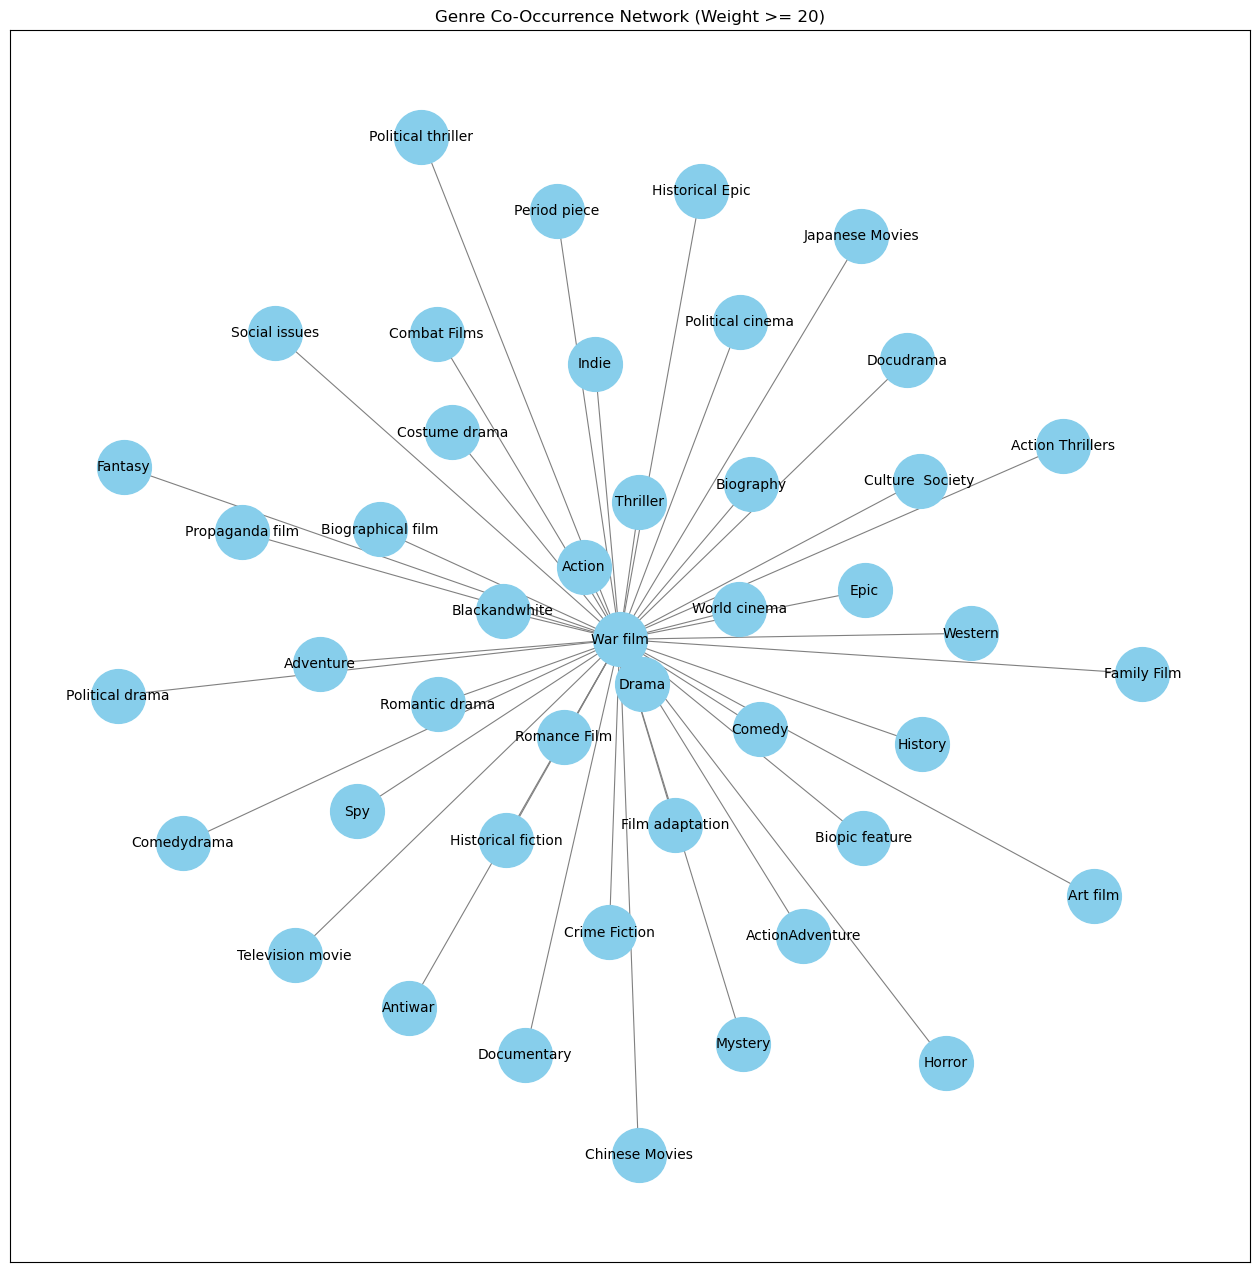

In [2128]:
from itertools import combinations
from collections import Counter
import networkx as nx


def genre_co_occurrence_network(df_movies, genres, min_weight):
    '''
    Build and visualize a simplified co-occurrence network of genres
    Parameters:
    - df_movies
    - genres: genres for co-occurrence
    - min_weight: minimum co-occurrence count to include an edge.
    '''
    # Extract genre pairs from each movie
    genre_combinations = df_movies["Genres"].apply(lambda x: list(combinations(x, 2)))
    co_occurrence = Counter([pair for sublist in genre_combinations for pair in sublist])

    # Convert to a DataFrame
    co_occurrence_df = pd.DataFrame(co_occurrence.items(), columns=["Pair", "Count"])
    co_occurrence_df["Genre1"] = co_occurrence_df["Pair"].apply(lambda x: x[0])
    co_occurrence_df["Genre2"] = co_occurrence_df["Pair"].apply(lambda x: x[1])

    # Filter by weight and chosen genres
    filtered_df = co_occurrence_df[
        ((co_occurrence_df["Genre1"].isin(genres)) | (co_occurrence_df["Genre2"].isin(genres))) &
        (co_occurrence_df["Count"] >= min_weight)
    ]

    # Build a simplified network
    G = nx.Graph()
    for _, row in filtered_df.iterrows():
        G.add_edge(row["Genre1"], row["Genre2"], weight=row["Count"])

    # Visualize the simplified network
    plt.figure(figsize=(16, 16))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="skyblue")

    # Make edges thinner
    nx.draw_networkx_edges(G, pos, width=0.8, edge_color="gray")

    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
    plt.title(f"Genre Co-Occurrence Network (Weight >= {min_weight})")
    plt.show()

war_genres = ["War film"]
genre_co_occurrence_network(df_movies, war_genres, min_weight=20)

In [2129]:
from scipy.stats import chi2_contingency

def genre_shifts_analysis(df_movies, war_start_year, war_end_year, name, window=5):
    '''
    Analyzes genre shifts before, during, and after a war using chi-square test.
    '''
    # Time window for "before" and "after"
    before_period = df_movies[(df_movies["Year"] >= war_start_year - window) & (df_movies["Year"] < war_start_year)]
    during_period = df_movies[(df_movies["Year"] >= war_start_year) & (df_movies["Year"] <= war_end_year)]
    after_period = df_movies[(df_movies["Year"] > war_end_year) & (df_movies["Year"] <= war_end_year + window)]

    # Count genres in each period
    before = before_period["Genres"].explode().value_counts()
    during = during_period["Genres"].explode().value_counts()
    after = after_period["Genres"].explode().value_counts()

    # Contingency table
    contingency_table = pd.concat([before, during, after], axis=1, keys=["Before", "During", "After"]).fillna(0)
    # Chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Calculate residuals
    residuals = (contingency_table - expected) / np.sqrt(expected)
    # Find genres with the largest absolute residuals 
    top_residual_genres = residuals.abs().max(axis=1).sort_values(ascending=False).head(10).index
    # Filter the contingency table to include only top genres
    filtered_table = contingency_table.loc[top_residual_genres]
    # Normalize for proportions
    filtered_proportions = filtered_table.div(filtered_table.sum(axis=0), axis=1)

    # Plot filtered proportions
    fig = go.Figure()

    # Add traces for each time period (Before, During, After)
    for time_period in filtered_proportions.columns:
        fig.add_trace(go.Bar(
            x=filtered_proportions.index,
            y=filtered_proportions[time_period],
            name=time_period
        ))

    # Layout
    fig.update_layout(
        barmode='stack', 
        title=f"Top Genres with Significant Changes Before, During, and After {name} War",
        xaxis=dict(title="Genres"),
        yaxis=dict(title="Proportion"),
        legend_title="Time Periods",
        template="plotly_white",
        width=900,
        height=600
    )
    fig.show()

# Example usage
genre_shifts_analysis(df_movies,1939, 1945, "Second World", window=5)
genre_shifts_analysis(df_movies, 1980, 1988, "Iran-Iraq", window=5)
genre_shifts_analysis(df_movies, 1965, 1975, "Vietnam", window=5)
genre_shifts_analysis(df_movies, 1950, 1953, "Korean", window=5)
genre_shifts_analysis(df_movies, 1947, 1991, "Cold", window=5)

In [ ]:
def war_analysis(df_movies, init_year, fin_year, war_name):
    '''
    Analyzes movie genres' proportions during and around (+-2) a specific war and plots.
    
    Parameters:
    - df_movies 
    - init_year: Starting year for the plot (war start year - 2).
    - fin_year: Ending year for the plot (war end year + 2).
    - war_name: name of the war
    '''

    def stacked_bar_plot_by_genres(df_movies, genre_list, init_year, fin_year, title):
        '''
        Creates an interactive stacked bar plot using Plotly for specified genres over a year range.

        Parameters:
        - df_movies
        - genre_list: group of genres 
        - init_year
        - fin_year
        - title: Title of the plot.
        '''

        stacked_data = pd.DataFrame()
        
        for genre in genre_list:
            # Use count_genre_proportion to calculate proportions for the genre over time
            films_genre = count_genre_proportion(df_movies, genre)
            # Filter by the year range
            films_genre = films_genre[(films_genre["Year"] >= init_year) & (films_genre["Year"] <= fin_year)]
            # Add to stacked_data 
            stacked_data[genre] = films_genre.set_index("Year")["Proportion"]
        
        # Fill null values with 0 
        stacked_data = stacked_data.fillna(0)

        # Ensure all years are present
        all_years = pd.Series(range(init_year, fin_year + 1), name="Year")
        stacked_data = stacked_data.reindex(all_years, fill_value=0).reset_index()
        stacked_data.rename(columns={"index": "Year"}, inplace=True)

        # Create Plotly stacked bar plot
        fig = go.Figure()

        for genre in genre_list:
            fig.add_trace(go.Bar(
                x=stacked_data['Year'],
                y=stacked_data[genre],
                name=genre
            ))

        # Update layout
        fig.update_layout(
            barmode='stack',
            title=title,
            xaxis=dict(title="Year"),
            yaxis=dict(title="Proportion"),
            legend=dict(
                x=1, y=1, xanchor='right', yanchor='top',
                bgcolor='rgba(255,255,255,0.8)',
                bordercolor="Black",
                borderwidth=1
            ),
            template="plotly_white",
            width=1000,
            height=600
        )

        fig.show()

    # Run the function for each group of genres
    stacked_bar_plot_by_genres(
        df_movies=df_movies,
        genre_list=reflecting_genres,
        init_year=init_year,
        fin_year=fin_year,
        title=f"{war_name} War: Proportions of Political Genres Over Time"
    )

    stacked_bar_plot_by_genres(
        df_movies=df_movies,
        genre_list=military_and_antiwar,
        init_year=init_year,
        fin_year=fin_year,
        title=f"{war_name} War: Proportions of Military Genres Over Time"
    )

    stacked_bar_plot_by_genres(
        df_movies=df_movies,
        genre_list=dystopian_genres,
        init_year=init_year,
        fin_year=fin_year,
        title=f"{war_name} War: Proportions of Dystopian Genres Over Time"
    )

    positive_genres = ["Family Film", "Romance Film", "Romantic comedy", "Comedy", "Fantasy"]
    stacked_bar_plot_by_genres(
        df_movies=df_movies,
        genre_list=positive_genres,
        init_year=init_year,
        fin_year=fin_year,
        title=f"{war_name} War: Proportions of Positive Genres Over Time"
    )

def pick_years(chosen_wars, i):
    '''
    Calculate init_year and fin_year for each chosen war
    
    Parameters:
    - chosen_wars: DataFrame containing war data with 'StartYear', 'EndYear', and 'WarName' for the chosen wars
    - i: Index of the chosen war in the DataFrame.
    '''
    startyear = chosen_wars.iloc[i]["StartYear"]
    endyear = chosen_wars.iloc[i]["EndYear"]
    war_name = chosen_wars.iloc[i]["WarName"]
    init_year = startyear - 2
    fin_year = endyear + 2
    return init_year, fin_year, war_name

# Loop through all wars and generate plots
for i in range(len(chosen_wars)):
    start, end, war_name = pick_years(chosen_wars, i)
    war_analysis(df_movies, start, end, war_name)